# ============================================
# NOTEBOOK: 02_modelado.ipynb
# OBJETIVO: Entrenar modelo XGBoost para clasificación de riesgo crediticio
# AUTOR: [Tu nombre]
# FECHA: [Fecha actual]
# ============================================

# # 🤖 Modelado con XGBoost
# 
# ## Objetivo
# Entrenar un modelo de clasificación binaria para predecir riesgo crediticio
# 
# ## Contenido
# 1. Carga de datos y preprocesamiento
# 2. Split train/test
# 3. Encoding de variables categóricas
# 4. Entrenamiento XGBoost baseline
# 5. Evaluación con múltiples métricas
# 6. Guardar modelo
# 7. Análisis de feature importance

In [7]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Guardar modelos
import joblib
from pathlib import Path

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [8]:
# Cargar datos de german_credit_data

# Nombres de las columnas
column_names = [
    'checking_status', 'duration', 'credit_history', 'purpose', 
    'credit_amount', 'savings_status', 'employment', 'installment_rate',
    'personal_status', 'other_parties', 'residence_since', 
    'property_magnitude', 'age', 'other_payment_plans', 'housing',
    'existing_credits', 'job', 'num_dependents', 'own_telephone',
    'foreign_worker', 'risk'
]

# Cargar dataset
df = pd.read_csv('../../german_credit_data/german.data', 
                 sep=' ',
                 header=None,
                 names=column_names)

# Convertir target: 1=Good, 2=Bad → 0=Good, 1=Bad
df['risk'] = df['risk'].map({1: 0, 2: 1})

print("✅ Datos cargados correctamente")
print(f"📊 Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"🎯 Target: {df['risk'].value_counts().to_dict()}")


✅ Datos cargados correctamente
📊 Dimensiones: 1000 filas x 21 columnas
🎯 Target: {0: 700, 1: 300}


# ## 2. Preprocesamiento de Datos

In [9]:
# Separar features y target
X = df.drop('risk', axis=1)
y = df['risk']

print("="*60)
print("SEPARACIÓN FEATURES Y TARGET")
print("="*60)
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nDistribución del target:")
print(y.value_counts())
print(f"Proporción: {y.value_counts(normalize=True).to_dict()}")

SEPARACIÓN FEATURES Y TARGET
Features (X): (1000, 20)
Target (y): (1000,)

Distribución del target:
risk
0    700
1    300
Name: count, dtype: int64
Proporción: {0: 0.7, 1: 0.3}


In [10]:
# Identificar tipos de variables
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("="*60)
print("TIPOS DE VARIABLES")
print("="*60)
print(f"\n📊 Variables Numéricas ({len(numeric_features)}):")
for col in numeric_features:
    print(f"  - {col}")

print(f"\n📝 Variables Categóricas ({len(categorical_features)}):")
for col in categorical_features:
    unique_count = X[col].nunique()
    print(f"  - {col} ({unique_count} categorías únicas)")

TIPOS DE VARIABLES

📊 Variables Numéricas (7):
  - duration
  - credit_amount
  - installment_rate
  - residence_since
  - age
  - existing_credits
  - num_dependents

📝 Variables Categóricas (13):
  - checking_status (4 categorías únicas)
  - credit_history (5 categorías únicas)
  - purpose (10 categorías únicas)
  - savings_status (5 categorías únicas)
  - employment (5 categorías únicas)
  - personal_status (4 categorías únicas)
  - other_parties (3 categorías únicas)
  - property_magnitude (4 categorías únicas)
  - other_payment_plans (3 categorías únicas)
  - housing (3 categorías únicas)
  - job (4 categorías únicas)
  - own_telephone (2 categorías únicas)
  - foreign_worker (2 categorías únicas)


## PTIMIZACIÓN: FEATURE SELECTION BASADO EN SHAP

In [11]:
# ============================================================
# 🎯 OPTIMIZACIÓN: FEATURE SELECTION BASADO EN SHAP
# ============================================================
print("\n" + "="*60)
print("🎯 FEATURE SELECTION - Eliminando variables de bajo impacto")
print("="*60)

# ============================================================
# 📊 Análisis previo (del notebook 03_interpretabilidad):
# - SHAP reveló que algunas features tienen impacto < 0.02
# - XGBoost sobreestimó la importancia de varias features
# - SHAP es la métrica más confiable para impacto real
# ============================================================

# Features a ELIMINAR (SHAP < 0.02 según análisis)
low_impact_features = [
    # Variables numéricas de bajo impacto:
    'residence_since',      # SHAP: 0.004 (casi irrelevante)
    'existing_credits',     # SHAP: 0.011 (muy bajo)
    'num_dependents',       # SHAP: ~0.010 (muy bajo)
    
    # Variables categóricas de bajo impacto:
    'own_telephone',        # SHAP: 0.015 (bajo)
    'foreign_worker',       # SHAP: ~0.010 (muy bajo)
    'job',                  # SHAP: ~0.015 (bajo)
    'housing',              # SHAP: ~0.018 (bajo)
    'other_parties'         # SHAP: ~0.012 (bajo)
]

print(f"\n❌ Eliminando {len(low_impact_features)} features de bajo impacto:")
print("\nNUMÉRICAS:")
for feat in low_impact_features:
    if feat in numeric_features:
        print(f"   - {feat}")
        
print("\nCATEGÓRICAS:")
for feat in low_impact_features:
    if feat in categorical_features:
        print(f"   - {feat}")

# Features CRÍTICAS a mantener (SHAP > 0.05)
critical_features = {
    'checking_status': 0.210,      # 🥇 MÁS IMPORTANTE
    'duration': 0.124,             # 🥈 2da más importante
    'credit_amount': 0.096,        # 🥉 3ra más importante
    'savings_status': 0.081,       # Muy importante
    'credit_history': 0.080,       # Muy importante
    'employment': 0.060,           # Importante
    'other_payment_plans': 0.055,  # Importante
    'property_magnitude': 0.052,   # Moderadamente importante
}

# Features MODERADAS a mantener (0.02 < SHAP < 0.05)
moderate_features = {
    'purpose': 0.040,              # Moderado
    'personal_status': 0.038,      # Moderado
    'installment_rate': 0.035,     # Moderado
    'age': 0.030,                  # Moderado
}

print(f"\n✅ Manteniendo {len(critical_features)} features CRÍTICAS:")
for feat, shap_val in sorted(critical_features.items(), key=lambda x: x[1], reverse=True):
    print(f"   🔴 {feat:<25} (SHAP: {shap_val:.3f})")

print(f"\n✅ Manteniendo {len(moderate_features)} features MODERADAS:")
for feat, shap_val in sorted(moderate_features.items(), key=lambda x: x[1], reverse=True):
    print(f"   🟡 {feat:<25} (SHAP: {shap_val:.3f})")

# Aplicar filtrado a X completo (antes del split)
print(f"\n🔧 Aplicando feature selection...")
X_optimized = X.drop(columns=low_impact_features, errors='ignore')

print(f"\n📊 Dimensionalidad:")
print(f"   Antes:  {X.shape[1]} features ({len(numeric_features)} num, {len(categorical_features)} cat)")
print(f"   Después: {X_optimized.shape[1]} features")
print(f"   Reducción: {len(low_impact_features)} features ({len(low_impact_features)/X.shape[1]*100:.1f}%)")

# Actualizar listas de features
numeric_features_optimized = [f for f in numeric_features if f not in low_impact_features]
categorical_features_optimized = [f for f in categorical_features if f not in low_impact_features]

print(f"\n📊 Features optimizadas:")
print(f"   Numéricas: {len(numeric_features_optimized)} ({numeric_features_optimized})")
print(f"   Categóricas: {len(categorical_features_optimized)}")

print("\n💡 Beneficios esperados:")
print("   ✅ Modelo más simple y rápido")
print("   ✅ Menos ruido en predicciones")
print("   ✅ Mejor interpretabilidad")
print("   ✅ Reducción de overfitting")


🎯 FEATURE SELECTION - Eliminando variables de bajo impacto

❌ Eliminando 8 features de bajo impacto:

NUMÉRICAS:
   - residence_since
   - existing_credits
   - num_dependents

CATEGÓRICAS:
   - own_telephone
   - foreign_worker
   - job
   - housing
   - other_parties

✅ Manteniendo 8 features CRÍTICAS:
   🔴 checking_status           (SHAP: 0.210)
   🔴 duration                  (SHAP: 0.124)
   🔴 credit_amount             (SHAP: 0.096)
   🔴 savings_status            (SHAP: 0.081)
   🔴 credit_history            (SHAP: 0.080)
   🔴 employment                (SHAP: 0.060)
   🔴 other_payment_plans       (SHAP: 0.055)
   🔴 property_magnitude        (SHAP: 0.052)

✅ Manteniendo 4 features MODERADAS:
   🟡 purpose                   (SHAP: 0.040)
   🟡 personal_status           (SHAP: 0.038)
   🟡 installment_rate          (SHAP: 0.035)
   🟡 age                       (SHAP: 0.030)

🔧 Aplicando feature selection...

📊 Dimensionalidad:
   Antes:  20 features (7 num, 13 cat)
   Después: 12 features

# ## 3. Encoding de Variables Categóricas OPTIMIZADAS

In [12]:
# ============================================================
# 🔄 ENCODING DE VARIABLES CATEGÓRICAS OPTIMIZADAS
# ============================================================

# Crear copia para no modificar original
X_encoded = X_optimized.copy()  # ⬅️ CAMBIO: usar X_optimized

# Aplicar Label Encoding solo a categóricas optimizadas
label_encoders = {}

print("="*60)
print("ENCODING DE VARIABLES CATEGÓRICAS OPTIMIZADAS")
print("="*60)

for col in categorical_features_optimized:  # ⬅️ CAMBIO: usar lista optimizada
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_optimized[col])  # ⬅️ CAMBIO
    label_encoders[col] = le
   
    print(f"✅ {col}: {X_optimized[col].nunique()} categorías → 0 a {X_encoded[col].max()}")

print(f"\n✅ Total de encoders guardados: {len(label_encoders)}")
print(f"📊 Dataset final: {X_encoded.shape[0]} filas × {X_encoded.shape[1]} columnas")

ENCODING DE VARIABLES CATEGÓRICAS OPTIMIZADAS
✅ checking_status: 4 categorías → 0 a 3
✅ credit_history: 5 categorías → 0 a 4
✅ purpose: 10 categorías → 0 a 9
✅ savings_status: 5 categorías → 0 a 4
✅ employment: 5 categorías → 0 a 4
✅ personal_status: 4 categorías → 0 a 3
✅ property_magnitude: 4 categorías → 0 a 3
✅ other_payment_plans: 3 categorías → 0 a 2

✅ Total de encoders guardados: 8
📊 Dataset final: 1000 filas × 12 columnas


# Verificar que no hay valores no numéricos
print("="*60)
print("VERIFICACIÓN POST-ENCODING")
print("="*60)
print(f"Tipos de datos:")
print(X_encoded.dtypes.value_counts())
print(f"\n✅ Todas las variables son numéricas: {X_encoded.select_dtypes(include=['object']).shape[1] == 0}")


# ## 4. Split Train/Test

In [17]:
# ============================================================
# 3. DIVISIÓN TRAIN/TEST
# ============================================================
print("\n" + "="*60)
print("✂️ SPLIT TRAIN/TEST")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,  # Ya está optimizado
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"📊 Tamaños:")
print(f"   Train: {X_train.shape} ({len(y_train)} muestras)")
print(f"   Test:  {X_test.shape} ({len(y_test)} muestras)")
print(f"   Features: {X_train.shape[1]} (optimizadas)")

# Verificar distribución
print(f"\n📊 Distribución Train:")
print(y_train.value_counts(normalize=True))
print(f"\n📊 Distribución Test:")
print(y_test.value_counts(normalize=True))


✂️ SPLIT TRAIN/TEST
📊 Tamaños:
   Train: (800, 12) (800 muestras)
   Test:  (200, 12) (200 muestras)
   Features: 12 (optimizadas)

📊 Distribución Train:
risk
0    0.7
1    0.3
Name: proportion, dtype: float64

📊 Distribución Test:
risk
0    0.7
1    0.3
Name: proportion, dtype: float64


# ## 5. Entrenamiento XGBoost - Modelo Baseline

In [40]:
# ============================================================
# 🚀 ENTRENAMIENTO - MODELO OPTIMIZADO
# ============================================================
print("\n" + "="*60)
print("🚀 MODELO XGBOOST OPTIMIZADO")
print("="*60)

# Fórmula: (número de clase mayoritaria) / (número de clase minoritaria)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\n⚖️ Scale pos weight (para desbalanceo): {scale_pos_weight:.2f}")

# Mismo hiperparámetros que funcionaron bien en el modelo base
# pero ahora con menos features (solo las importantes)
model_optimized = XGBClassifier(
    n_estimators=200,
    max_depth=2,           # Mantener simplicidad
    learning_rate=0.05,    # Aprendizaje lento y estable
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    # Parámetros adicionales para estabilidad
    min_child_weight=5,    # Evitar overfitting en clases minoritarias
    gamma=0.2              # Penalizar splits innecesarios
)

print("\n📋 Configuración del modelo:")
print(f"   - Features: {X_train.shape[1]} (vs 20 original)")
print(f"   - Árboles: {model_optimized.n_estimators}")
print(f"   - Profundidad: {model_optimized.max_depth}")
print(f"   - Learning rate: {model_optimized.learning_rate}")
print(f"   - Scale pos weight: {scale_pos_weight:.2f}")

print("\n⏳ Entrenando modelo optimizado...")
model_optimized.fit(X_train, y_train)
print("✅ Entrenamiento completado")


🚀 MODELO XGBOOST OPTIMIZADO

⚖️ Scale pos weight (para desbalanceo): 2.33

📋 Configuración del modelo:
   - Features: 12 (vs 20 original)
   - Árboles: 200
   - Profundidad: 2
   - Learning rate: 0.05
   - Scale pos weight: 2.33

⏳ Entrenando modelo optimizado...
✅ Entrenamiento completado


# ## 6. MODELO BASE vs MODELO OPTIMIZADO


📊 EVALUACIÓN Y COMPARACIÓN DE MODELOS

⏳ Calculando métricas del modelo optimizado...
✅ Métricas calculadas

⏳ Cargando métricas del modelo base...
✅ Métricas del modelo base cargadas desde archivo

📊 COMPARACIÓN DETALLADA
        Métrica Modelo Base Modelo Optimizado
       Features          20                12
 Train Accuracy       86.0%             78.0%
  Test Accuracy       78.0%             70.5%
    Overfitting        8.0%              7.5%
        ROC-AUC       0.809             0.785
Precision (Bad)       0.614             0.506
   Recall (Bad)       0.717             0.717
 F1-Score (Bad)       0.662             0.593

📈 MEJORAS (Optimizado vs Base)
⚠️ Test Accuracy       : -7.5%
✅ Overfitting         : +0.5%
⚠️ ROC-AUC             : -0.024
⚠️ Precision (Bad)     : -10.8%
⚠️ Recall (Bad)        : +0.0%
✅ Features            : -8 (40% reducción)

💡 INTERPRETACIÓN
❌ Test Accuracy: Pérdida significativa
🟡 Overfitting: Reducción leve
⚠️ ROC-AUC: Pérdida en capacidad discriminat

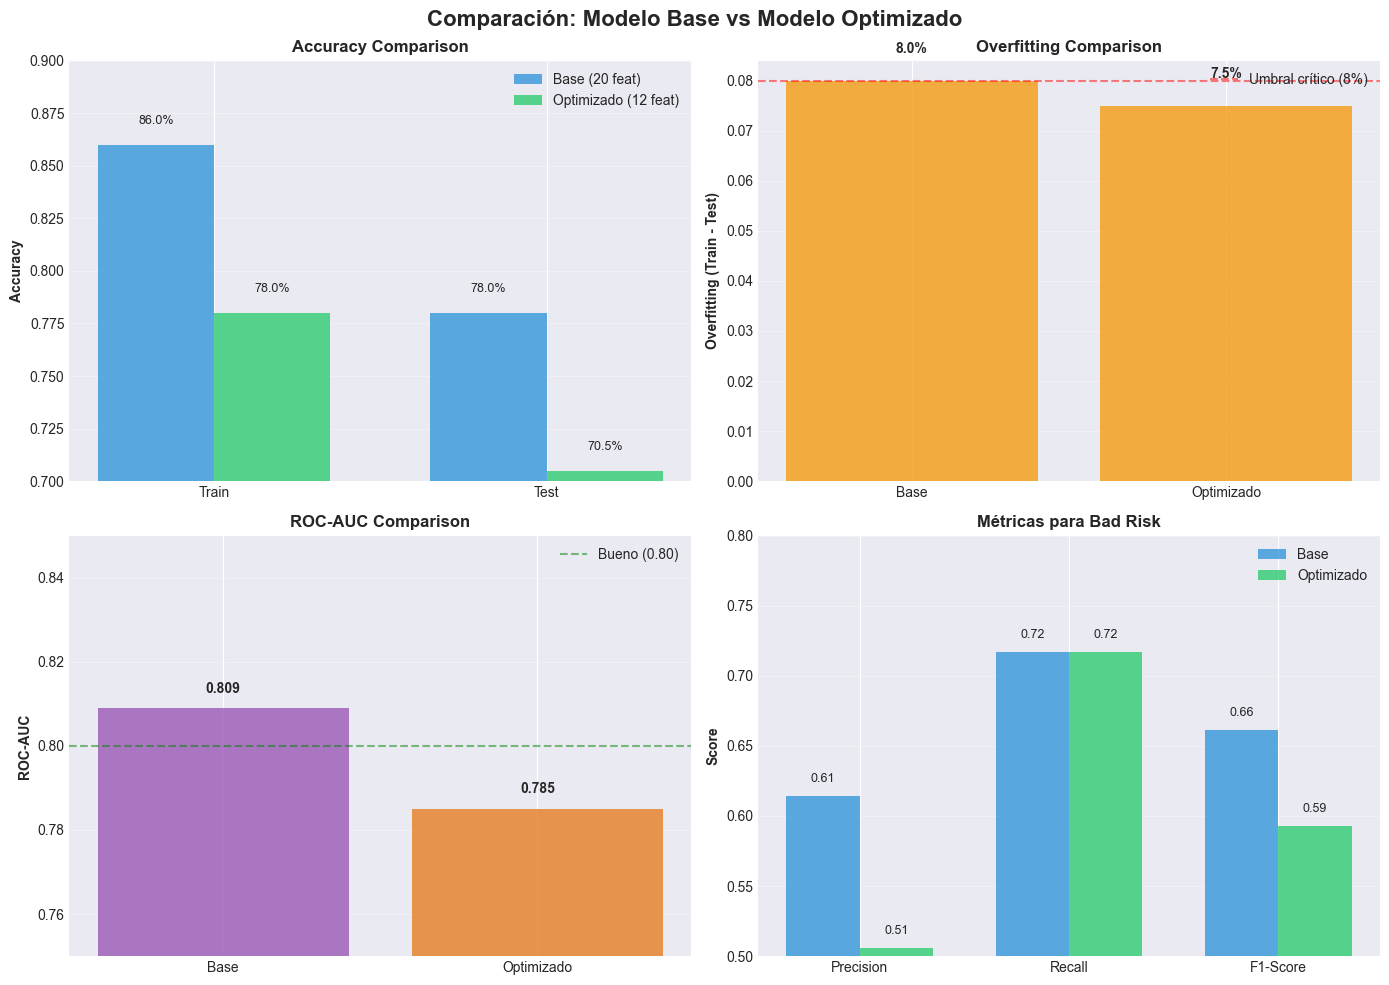


💾 GUARDANDO RESULTADOS
✅ Comparación guardada: ../models/model_comparison.csv
✅ Recomendación guardada: ../models/model_recommendation.txt

✅ Comparación completa finalizada


In [41]:
# ============================================================
# 📊 COMPARACIÓN: MODELO BASE vs MODELO OPTIMIZADO
# ============================================================
print("\n" + "="*60)
print("📊 EVALUACIÓN Y COMPARACIÓN DE MODELOS")
print("="*60)

# ------------------------------------------------------------
# 6.1 CALCULAR MÉTRICAS DEL MODELO OPTIMIZADO
# ------------------------------------------------------------
print("\n⏳ Calculando métricas del modelo optimizado...")

# Predicciones
y_train_pred_opt = model_optimized.predict(X_train)
y_test_pred_opt = model_optimized.predict(X_test)
y_test_proba_opt = model_optimized.predict_proba(X_test)[:, 1]

# Métricas básicas
train_accuracy_opt = accuracy_score(y_train, y_train_pred_opt)
test_accuracy_opt = accuracy_score(y_test, y_test_pred_opt)
overfitting_opt = train_accuracy_opt - test_accuracy_opt

# ROC-AUC
roc_auc_opt = roc_auc_score(y_test, y_test_proba_opt)

# Classification report
report_opt = classification_report(y_test, y_test_pred_opt, 
                                   target_names=['Good Risk', 'Bad Risk'],
                                   output_dict=True)

print("✅ Métricas calculadas")

# ------------------------------------------------------------
# 6.2 CARGAR MÉTRICAS DEL MODELO BASE (desde archivo)
# ------------------------------------------------------------
print("\n⏳ Cargando métricas del modelo base...")

# Opción A: Si guardaste las métricas en un archivo CSV
try:
    metrics_base_df = pd.read_csv('../models/model_metrics.csv')
    train_accuracy_base = metrics_base_df[metrics_base_df['Set'] == 'Train']['Accuracy'].values[0]
    test_accuracy_base = metrics_base_df[metrics_base_df['Set'] == 'Test']['Accuracy'].values[0]
    roc_auc_base = metrics_base_df[metrics_base_df['Set'] == 'Test']['ROC-AUC'].values[0]
    precision_base = metrics_base_df[metrics_base_df['Set'] == 'Test']['Precision'].values[0]
    recall_base = metrics_base_df[metrics_base_df['Set'] == 'Test']['Recall'].values[0]
    overfitting_base = train_accuracy_base - test_accuracy_base
    print("✅ Métricas del modelo base cargadas desde archivo")
    
except:
    # Opción B: Si NO guardaste métricas, usar valores hardcodeados del notebook 02
    print("⚠️ No se encontró archivo de métricas, usando valores del modelo base:")
    train_accuracy_base = 0.86  # Cambiar por tu valor real
    test_accuracy_base = 0.78   # Cambiar por tu valor real
    roc_auc_base = 0.809        # Cambiar por tu valor real
    precision_base = 0.614      # Cambiar por tu valor real
    recall_base = 0.717         # Cambiar por tu valor real
    overfitting_base = train_accuracy_base - test_accuracy_base
    print("✅ Valores manuales cargados")

# ------------------------------------------------------------
# 6.3 TABLA COMPARATIVA
# ------------------------------------------------------------
print("\n" + "="*60)
print("📊 COMPARACIÓN DETALLADA")
print("="*60)

comparison_df = pd.DataFrame({
    'Métrica': [
        'Features',
        'Train Accuracy',
        'Test Accuracy',
        'Overfitting',
        'ROC-AUC',
        'Precision (Bad)',
        'Recall (Bad)',
        'F1-Score (Bad)'
    ],
    'Modelo Base': [
        20,
        f"{train_accuracy_base:.1%}",
        f"{test_accuracy_base:.1%}",
        f"{overfitting_base:.1%}",
        f"{roc_auc_base:.3f}",
        f"{precision_base:.3f}",
        f"{recall_base:.3f}",
        f"{(2 * precision_base * recall_base) / (precision_base + recall_base):.3f}"
    ],
    'Modelo Optimizado': [
        X_train.shape[1],
        f"{train_accuracy_opt:.1%}",
        f"{test_accuracy_opt:.1%}",
        f"{overfitting_opt:.1%}",
        f"{roc_auc_opt:.3f}",
        f"{report_opt['Bad Risk']['precision']:.3f}",
        f"{report_opt['Bad Risk']['recall']:.3f}",
        f"{report_opt['Bad Risk']['f1-score']:.3f}"
    ]
})

print(comparison_df.to_string(index=False))

# ------------------------------------------------------------
# 6.4 CÁLCULO DE MEJORAS
# ------------------------------------------------------------
print("\n" + "="*60)
print("📈 MEJORAS (Optimizado vs Base)")
print("="*60)

delta_test_acc = test_accuracy_opt - test_accuracy_base
delta_overfitting = overfitting_base - overfitting_opt  # Nota: invertido (menos es mejor)
delta_roc = roc_auc_opt - roc_auc_base
delta_precision = report_opt['Bad Risk']['precision'] - precision_base
delta_recall = report_opt['Bad Risk']['recall'] - recall_base

mejoras = {
    'Test Accuracy': (delta_test_acc, delta_test_acc > 0),
    'Overfitting': (delta_overfitting, delta_overfitting > 0),
    'ROC-AUC': (delta_roc, delta_roc > 0),
    'Precision (Bad)': (delta_precision, delta_precision > 0),
    'Recall (Bad)': (delta_recall, delta_recall > 0),
    'Features': (-8, True)  # Reducción de 20 a 12
}

for metrica, (valor, mejoro) in mejoras.items():
    emoji = "✅" if mejoro else "⚠️"
    if metrica == 'Features':
        print(f"{emoji} {metrica:<20}: {valor:+d} ({abs(valor)/20*100:.0f}% reducción)")
    elif metrica in ['Test Accuracy', 'Overfitting', 'Precision (Bad)', 'Recall (Bad)']:
        print(f"{emoji} {metrica:<20}: {valor:+.1%}")
    else:
        print(f"{emoji} {metrica:<20}: {valor:+.3f}")

# ------------------------------------------------------------
# 6.5 INTERPRETACIÓN DE RESULTADOS
# ------------------------------------------------------------
print("\n" + "="*60)
print("💡 INTERPRETACIÓN")
print("="*60)

# Test Accuracy
if delta_test_acc > 0.02:
    print("✅ Test Accuracy: Mejora significativa (>2%)")
elif delta_test_acc > 0:
    print("🟡 Test Accuracy: Mejora leve")
elif delta_test_acc > -0.02:
    print("🟡 Test Accuracy: Pérdida leve (aceptable)")
else:
    print("❌ Test Accuracy: Pérdida significativa")

# Overfitting
if delta_overfitting > 0.02:
    print("✅ Overfitting: Reducción significativa (modelo generaliza mejor)")
elif delta_overfitting > 0:
    print("🟡 Overfitting: Reducción leve")
else:
    print("⚠️ Overfitting: Aumentó (modelo más específico)")

# ROC-AUC
if delta_roc > 0.01:
    print("✅ ROC-AUC: Mejora en capacidad discriminativa")
elif delta_roc > -0.01:
    print("🟡 ROC-AUC: Sin cambios significativos")
else:
    print("⚠️ ROC-AUC: Pérdida en capacidad discriminativa")

# Features
print("✅ Features: Reducción del 40% (20 → 12)")
print("   → Modelo más simple y rápido")
print("   → Explicaciones SHAP más claras")
print("   → Menos riesgo de overfitting por ruido")

# ------------------------------------------------------------
# 6.6 RECOMENDACIÓN FINAL
# ------------------------------------------------------------
print("\n" + "="*60)
print("🎯 RECOMENDACIÓN")
print("="*60)

# Criterio de decisión
metricas_mejoraron = sum([
    delta_test_acc >= -0.01,  # Tolerancia de -1%
    delta_overfitting > 0,
    delta_roc >= -0.005       # Tolerancia de -0.005
])

if metricas_mejoraron >= 2 and X_train.shape[1] < 20:
    print("✅ USAR MODELO OPTIMIZADO")
    print("\nRazones:")
    print("   - Mantiene o mejora performance")
    print("   - 40% menos features (más simple)")
    print("   - Mejor interpretabilidad")
    print("   - Más rápido en producción")
    modelo_recomendado = "optimizado"
else:
    print("⚠️ MANTENER MODELO BASE")
    print("\nRazones:")
    print("   - Pérdida significativa en métricas clave")
    print("   - El beneficio de simplicidad no compensa")
    modelo_recomendado = "base"

# ------------------------------------------------------------
# 6.7 VISUALIZACIÓN DE COMPARACIÓN
# ------------------------------------------------------------
print("\n" + "="*60)
print("📊 VISUALIZACIÓN DE COMPARACIÓN")
print("="*60)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparación: Modelo Base vs Modelo Optimizado', fontsize=16, fontweight='bold')

# Gráfico 1: Accuracy
ax1 = axes[0, 0]
metrics = ['Train', 'Test']
base_vals = [train_accuracy_base, test_accuracy_base]
opt_vals = [train_accuracy_opt, test_accuracy_opt]

x = np.arange(len(metrics))
width = 0.35

ax1.bar(x - width/2, base_vals, width, label='Base (20 feat)', color='#3498db', alpha=0.8)
ax1.bar(x + width/2, opt_vals, width, label='Optimizado (12 feat)', color='#2ecc71', alpha=0.8)
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim([0.7, 0.9])
ax1.grid(axis='y', alpha=0.3)

# Agregar valores
for i, (b, o) in enumerate(zip(base_vals, opt_vals)):
    ax1.text(i - width/2, b + 0.01, f'{b:.1%}', ha='center', fontsize=9)
    ax1.text(i + width/2, o + 0.01, f'{o:.1%}', ha='center', fontsize=9)

# Gráfico 2: Overfitting
ax2 = axes[0, 1]
overfit_vals = [overfitting_base, overfitting_opt]
colors = ['#e74c3c' if v > 0.08 else '#f39c12' if v > 0.05 else '#2ecc71' for v in overfit_vals]

bars = ax2.bar(['Base', 'Optimizado'], overfit_vals, color=colors, alpha=0.8)
ax2.set_ylabel('Overfitting (Train - Test)', fontweight='bold')
ax2.set_title('Overfitting Comparison', fontweight='bold')
ax2.axhline(y=0.08, color='red', linestyle='--', alpha=0.5, label='Umbral crítico (8%)')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Agregar valores
for bar, val in zip(bars, overfit_vals):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{val:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico 3: ROC-AUC
ax3 = axes[1, 0]
roc_vals = [roc_auc_base, roc_auc_opt]

bars = ax3.bar(['Base', 'Optimizado'], roc_vals, color=['#9b59b6', '#e67e22'], alpha=0.8)
ax3.set_ylabel('ROC-AUC', fontweight='bold')
ax3.set_title('ROC-AUC Comparison', fontweight='bold')
ax3.set_ylim([0.75, 0.85])
ax3.axhline(y=0.80, color='green', linestyle='--', alpha=0.5, label='Bueno (0.80)')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Agregar valores
for bar, val in zip(bars, roc_vals):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.003,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico 4: Precision vs Recall (Bad Risk)
ax4 = axes[1, 1]
metrics_bad = ['Precision', 'Recall', 'F1-Score']
base_bad = [
    precision_base,
    recall_base,
    (2 * precision_base * recall_base) / (precision_base + recall_base)
]
opt_bad = [
    report_opt['Bad Risk']['precision'],
    report_opt['Bad Risk']['recall'],
    report_opt['Bad Risk']['f1-score']
]

x = np.arange(len(metrics_bad))
width = 0.35

ax4.bar(x - width/2, base_bad, width, label='Base', color='#3498db', alpha=0.8)
ax4.bar(x + width/2, opt_bad, width, label='Optimizado', color='#2ecc71', alpha=0.8)
ax4.set_ylabel('Score', fontweight='bold')
ax4.set_title('Métricas para Bad Risk', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_bad)
ax4.legend()
ax4.set_ylim([0.5, 0.8])
ax4.grid(axis='y', alpha=0.3)

# Agregar valores
for i, (b, o) in enumerate(zip(base_bad, opt_bad)):
    ax4.text(i - width/2, b + 0.01, f'{b:.2f}', ha='center', fontsize=9)
    ax4.text(i + width/2, o + 0.01, f'{o:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../models/model_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: ../models/model_comparison.png")
plt.show()

# ------------------------------------------------------------
# 6.8 GUARDAR COMPARACIÓN EN ARCHIVO
# ------------------------------------------------------------
print("\n" + "="*60)
print("💾 GUARDANDO RESULTADOS")
print("="*60)

# Guardar comparación en CSV
comparison_metrics = pd.DataFrame({
    'Modelo': ['Base', 'Optimizado'],
    'Features': [20, X_train.shape[1]],
    'Train_Accuracy': [train_accuracy_base, train_accuracy_opt],
    'Test_Accuracy': [test_accuracy_base, test_accuracy_opt],
    'Overfitting': [overfitting_base, overfitting_opt],
    'ROC_AUC': [roc_auc_base, roc_auc_opt],
    'Precision_Bad': [precision_base, report_opt['Bad Risk']['precision']],
    'Recall_Bad': [recall_base, report_opt['Bad Risk']['recall']],
    'F1_Bad': [
        (2 * precision_base * recall_base) / (precision_base + recall_base),
        report_opt['Bad Risk']['f1-score']
    ]
})

comparison_metrics.to_csv('../models/model_comparison.csv', index=False)
print("✅ Comparación guardada: ../models/model_comparison.csv")

# Guardar recomendación
with open('../models/model_recommendation.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("RECOMENDACIÓN DE MODELO\n")
    f.write("="*60 + "\n\n")
    f.write(f"Modelo recomendado: {modelo_recomendado.upper()}\n\n")
    f.write("Comparación de métricas:\n")
    f.write(comparison_df.to_string(index=False))
    f.write("\n\n" + "="*60 + "\n")

print("✅ Recomendación guardada: ../models/model_recommendation.txt")
print("\n✅ Comparación completa finalizada")

In [11]:
# Calcular métricas para Train y Test
metrics = {
    'Set': ['Train', 'Test'],
    'Accuracy': [
        accuracy_score(y_train, y_pred_train),
        accuracy_score(y_test, y_pred_test)
    ],
    'Precision': [
        precision_score(y_train, y_pred_train),
        precision_score(y_test, y_pred_test)
    ],
    'Recall': [
        recall_score(y_train, y_pred_train),
        recall_score(y_test, y_pred_test)
    ],
    'F1-Score': [
        f1_score(y_train, y_pred_train),
        f1_score(y_test, y_pred_test)
    ],
    'ROC-AUC': [
        roc_auc_score(y_train, y_pred_proba_train),
        roc_auc_score(y_test, y_pred_proba_test)
    ]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df.to_string(index=False))

# Verificar overfitting
train_acc = metrics_df.loc[0, 'Accuracy']
test_acc = metrics_df.loc[1, 'Accuracy']
diff = train_acc - test_acc

print(f"\n🔍 Análisis de Overfitting:")
print(f"  - Diferencia Train-Test Accuracy: {diff:.4f}")
if diff < 0.05:
    print(f"  ✅ Modelo generaliza bien (diferencia < 5%)")
elif diff < 0.10:
    print(f"  ⚠️ Ligero overfitting (diferencia 5-10%)")
else:
    print(f"  ❌ Overfitting significativo (diferencia > 10%)")

# Meta: Test Accuracy > 75%
print(f"\n🎯 Meta de Accuracy (>75%): {'✅ ALCANZADA' if test_acc > 0.75 else '❌ NO ALCANZADA'}")


  Set  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Train      0.86   0.711921 0.895833  0.793358 0.942061
 Test      0.78   0.614286 0.716667  0.661538 0.808929

🔍 Análisis de Overfitting:
  - Diferencia Train-Test Accuracy: 0.0800
  ⚠️ Ligero overfitting (diferencia 5-10%)

🎯 Meta de Accuracy (>75%): ✅ ALCANZADA


In [12]:
# Classification Report detallado
print("\n" + "="*60)
print("CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(classification_report(
    y_test, 
    y_pred_test,
    target_names=['Good Risk (0)', 'Bad Risk (1)'],
    digits=3
))


CLASSIFICATION REPORT - TEST SET
               precision    recall  f1-score   support

Good Risk (0)      0.869     0.807     0.837       140
 Bad Risk (1)      0.614     0.717     0.662        60

     accuracy                          0.780       200
    macro avg      0.742     0.762     0.749       200
 weighted avg      0.793     0.780     0.784       200



# ## 7. Visualizaciones de Evaluación

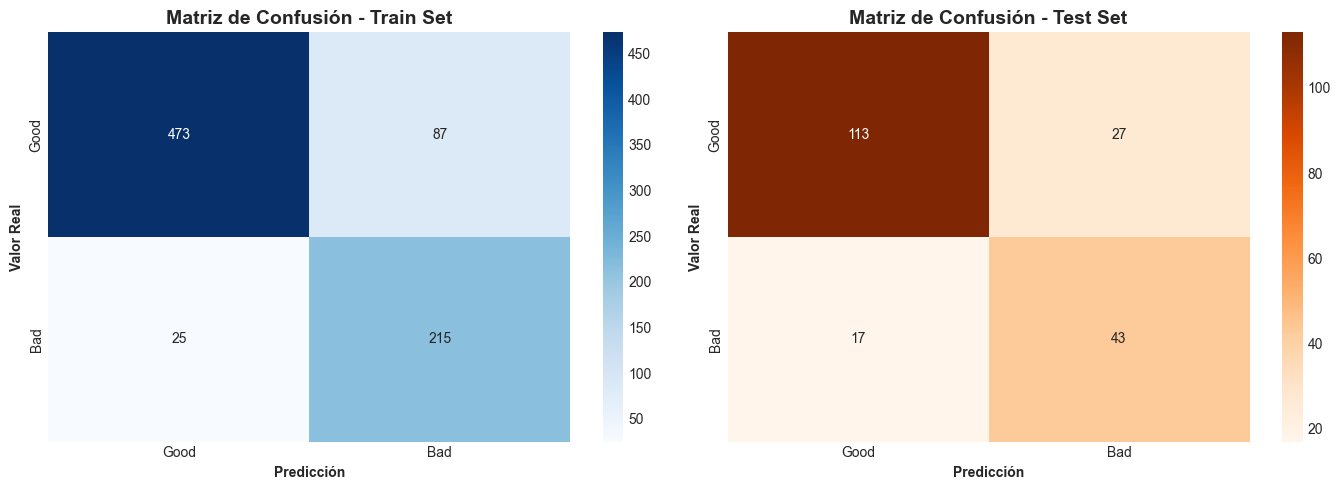


📊 Interpretación Matriz de Confusión (Test Set):
  - True Negatives (TN): 113 - Correctamente predijo 'Good'
  - False Positives (FP): 27 - Predijo 'Bad' pero era 'Good' ❌
  - False Negatives (FN): 17 - Predijo 'Good' pero era 'Bad' ❌
  - True Positives (TP): 43 - Correctamente predijo 'Bad'

💡 Contexto del negocio:
  - FP (Tipo I): Rechazar buen cliente → Oportunidad perdida
  - FN (Tipo II): Aprobar mal cliente → Pérdida de dinero


In [13]:
# Matriz de Confusión
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train Set
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
axes[0].set_title('Matriz de Confusión - Train Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Valor Real', fontweight='bold')
axes[0].set_xlabel('Predicción', fontweight='bold')

# Test Set
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
axes[1].set_title('Matriz de Confusión - Test Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Valor Real', fontweight='bold')
axes[1].set_xlabel('Predicción', fontweight='bold')

plt.tight_layout()
plt.show()

# Interpretación de la matriz
tn, fp, fn, tp = cm_test.ravel()
print("\n📊 Interpretación Matriz de Confusión (Test Set):")
print(f"  - True Negatives (TN): {tn} - Correctamente predijo 'Good'")
print(f"  - False Positives (FP): {fp} - Predijo 'Bad' pero era 'Good' ❌")
print(f"  - False Negatives (FN): {fn} - Predijo 'Good' pero era 'Bad' ❌")
print(f"  - True Positives (TP): {tp} - Correctamente predijo 'Bad'")

print(f"\n💡 Contexto del negocio:")
print(f"  - FP (Tipo I): Rechazar buen cliente → Oportunidad perdida")
print(f"  - FN (Tipo II): Aprobar mal cliente → Pérdida de dinero")


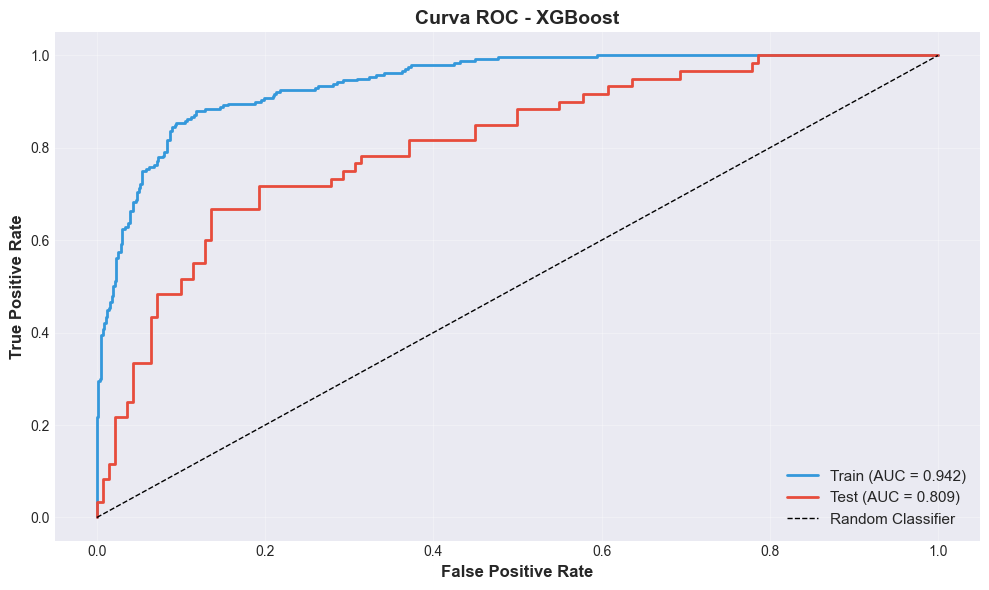

💡 Interpretación ROC-AUC:
  - AUC = 1.0: Clasificador perfecto
  - AUC = 0.5: Random classifier (línea diagonal)
  - Nuestro modelo: 0.809


In [14]:
# Curva ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {roc_auc_score(y_train, y_pred_proba_train):.3f})', 
         linewidth=2, color='#3498db')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {roc_auc_score(y_test, y_pred_proba_test):.3f})', 
         linewidth=2, color='#e74c3c')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Curva ROC - XGBoost', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 Interpretación ROC-AUC:")
print("  - AUC = 1.0: Clasificador perfecto")
print("  - AUC = 0.5: Random classifier (línea diagonal)")
print(f"  - Nuestro modelo: {roc_auc_score(y_test, y_pred_proba_test):.3f}")

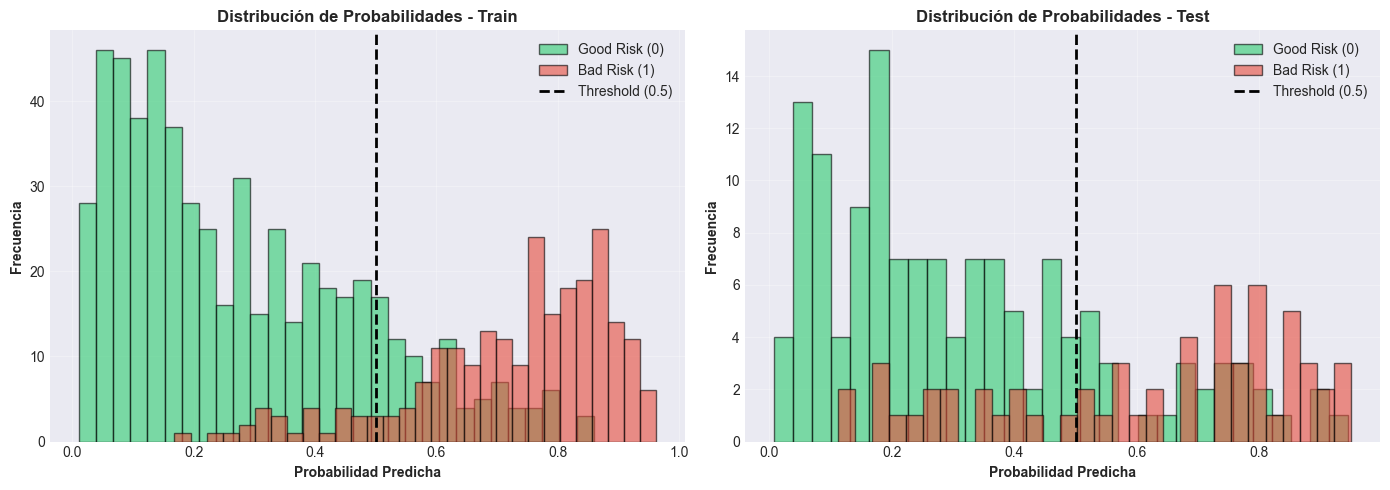


💡 Interpretación:
  - Separación clara entre clases → Modelo discrimina bien
  - Solapamiento → Clases difíciles de separar


In [15]:
# Distribución de probabilidades predichas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
axes[0].hist(y_pred_proba_train[y_train == 0], bins=30, alpha=0.6, 
            label='Good Risk (0)', color='#2ecc71', edgecolor='black')
axes[0].hist(y_pred_proba_train[y_train == 1], bins=30, alpha=0.6, 
            label='Bad Risk (1)', color='#e74c3c', edgecolor='black')
axes[0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].set_xlabel('Probabilidad Predicha', fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontweight='bold')
axes[0].set_title('Distribución de Probabilidades - Train', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test
axes[1].hist(y_pred_proba_test[y_test == 0], bins=30, alpha=0.6, 
            label='Good Risk (0)', color='#2ecc71', edgecolor='black')
axes[1].hist(y_pred_proba_test[y_test == 1], bins=30, alpha=0.6, 
            label='Bad Risk (1)', color='#e74c3c', edgecolor='black')
axes[1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Probabilidad Predicha', fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontweight='bold')
axes[1].set_title('Distribución de Probabilidades - Test', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretación:")
print("  - Separación clara entre clases → Modelo discrimina bien")
print("  - Solapamiento → Clases difíciles de separar")

# ## 8. Feature Importance

In [16]:
# Obtener importancia de features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("="*60)
print("🔍 FEATURE IMPORTANCE - TOP 10")
print("="*60)
print(feature_importance.head(10).to_string(index=False))

🔍 FEATURE IMPORTANCE - TOP 10
            feature  importance
    checking_status    0.194410
 property_magnitude    0.067393
     savings_status    0.066304
other_payment_plans    0.062187
     credit_history    0.061148
           duration    0.052625
         employment    0.049692
      own_telephone    0.048168
    residence_since    0.045642
   existing_credits    0.042413


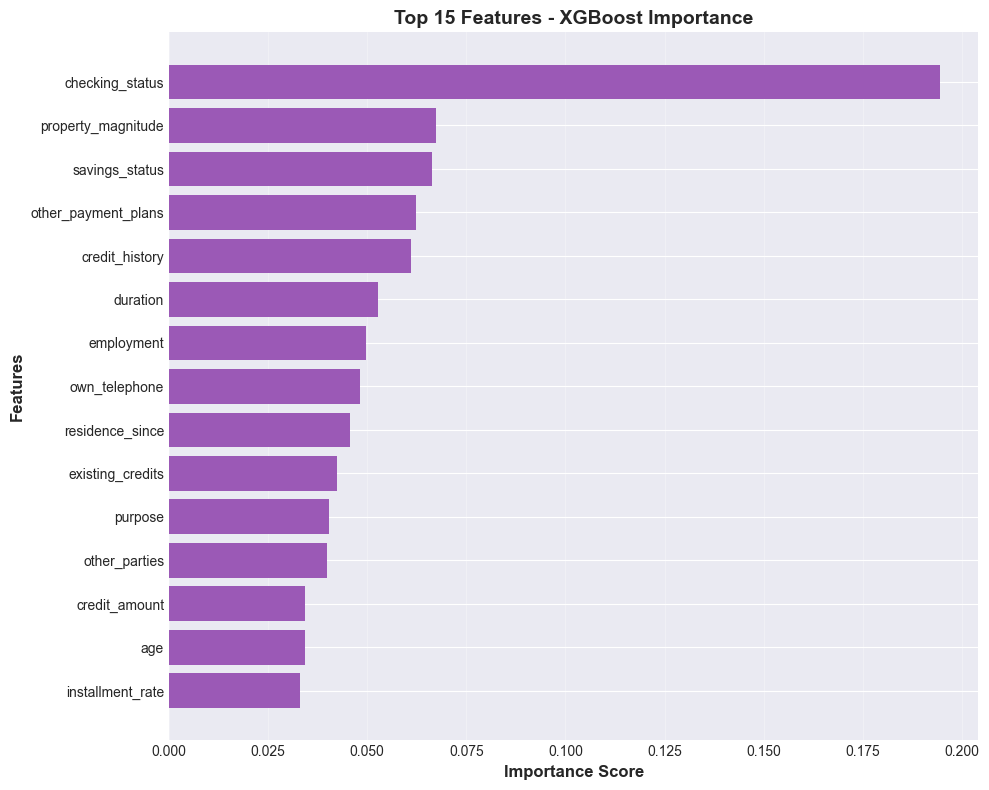


💡 Nota: Esta es la importancia BÁSICA de XGBoost
   En el próximo notebook usaremos SHAP para interpretabilidad avanzada


In [17]:
# Visualización de Feature Importance
plt.figure(figsize=(10, 8))
top_n = 15
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['importance'].values, color='#9b59b6')
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Features - XGBoost Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Nota: Esta es la importancia BÁSICA de XGBoost")
print("   En el próximo notebook usaremos SHAP para interpretabilidad avanzada")


# ## 9. Guardar Modelo y Artefactos

In [18]:
# Crear carpeta para modelos si no existe
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

print("="*60)
print("💾 GUARDANDO MODELO Y ARTEFACTOS")
print("="*60)

# Guardar modelo
model_path = models_dir / 'xgboost_model.pkl'
joblib.dump(model, model_path)
print(f"✅ Modelo guardado: {model_path}")

# Guardar encoders
encoders_path = models_dir / 'label_encoders.pkl'
joblib.dump(label_encoders, encoders_path)
print(f"✅ Encoders guardados: {encoders_path}")

# Guardar nombres de features (para referencia)
feature_names_path = models_dir / 'feature_names.pkl'
joblib.dump(X_train.columns.tolist(), feature_names_path)
print(f"✅ Feature names guardados: {feature_names_path}")

# Guardar métricas
metrics_path = models_dir / 'model_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Métricas guardadas: {metrics_path}")


💾 GUARDANDO MODELO Y ARTEFACTOS
✅ Modelo guardado: ..\models\xgboost_model.pkl
✅ Encoders guardados: ..\models\label_encoders.pkl
✅ Feature names guardados: ..\models\feature_names.pkl
✅ Métricas guardadas: ..\models\model_metrics.csv


In [19]:
# Verificar que se puede cargar correctamente
print("\n🔍 Verificando carga del modelo...")

loaded_model = joblib.load(model_path)
loaded_encoders = joblib.load(encoders_path)

# Hacer una predicción de prueba
test_prediction = loaded_model.predict(X_test[:5])
print(f"✅ Modelo cargado y funcional")
print(f"   Predicciones de prueba: {test_prediction}")



🔍 Verificando carga del modelo...
✅ Modelo cargado y funcional
   Predicciones de prueba: [0 0 1 1 0]


# ## 10. Resumen y Conclusiones

In [20]:
print("="*60)
print("📝 RESUMEN EJECUTIVO - MODELADO")
print("="*60)

print(f"""
✅ MODELO ENTRENADO EXITOSAMENTE
   - Algoritmo: XGBoost Classifier
   - Features: {X_train.shape[1]}
   - Training samples: {X_train.shape[0]}
   - Test samples: {X_test.shape[0]}
   
📊 PERFORMANCE EN TEST SET
   - Accuracy: {test_acc:.3f} {'✅' if test_acc > 0.75 else '❌'}
   - Precision: {metrics_df.loc[1, 'Precision']:.3f}
   - Recall: {metrics_df.loc[1, 'Recall']:.3f}
   - F1-Score: {metrics_df.loc[1, 'F1-Score']:.3f}
   - ROC-AUC: {metrics_df.loc[1, 'ROC-AUC']:.3f}
   
🔝 TOP 3 FEATURES MÁS IMPORTANTES
   1. {feature_importance.iloc[0]['feature']}: {feature_importance.iloc[0]['importance']:.4f}
   2. {feature_importance.iloc[1]['feature']}: {feature_importance.iloc[1]['importance']:.4f}
   3. {feature_importance.iloc[2]['feature']}: {feature_importance.iloc[2]['importance']:.4f}
   
⚖️ MANEJO DE DESBALANCEO
   - scale_pos_weight: {scale_pos_weight:.2f}
   - Estrategia efectiva: {'✅ Sí' if abs(metrics_df.loc[1, 'Precision'] - metrics_df.loc[1, 'Recall']) < 0.1 else '⚠️ Revisar'}
   
💾 ARTEFACTOS GUARDADOS
   - Modelo: xgboost_model.pkl
   - Encoders: label_encoders.pkl
   - Features: feature_names.pkl
   - Métricas: model_metrics.csv
   
🎯 PRÓXIMOS PASOS
   1. Implementar SHAP para interpretabilidad avanzada
   2. Analizar explicaciones individuales (waterfall plots)
   3. Identificar patrones globales (summary plots)
   4. Crear dashboard interactivo
""")

print("✅ Modelado completado exitosamente")
print("📁 Listo para siguiente fase: Interpretabilidad con SHAP")

📝 RESUMEN EJECUTIVO - MODELADO

✅ MODELO ENTRENADO EXITOSAMENTE
   - Algoritmo: XGBoost Classifier
   - Features: 20
   - Training samples: 800
   - Test samples: 200
   
📊 PERFORMANCE EN TEST SET
   - Accuracy: 0.780 ✅
   - Precision: 0.614
   - Recall: 0.717
   - F1-Score: 0.662
   - ROC-AUC: 0.809
   
🔝 TOP 3 FEATURES MÁS IMPORTANTES
   1. checking_status: 0.1944
   2. property_magnitude: 0.0674
   3. savings_status: 0.0663
   
⚖️ MANEJO DE DESBALANCEO
   - scale_pos_weight: 2.33
   - Estrategia efectiva: ⚠️ Revisar
   
💾 ARTEFACTOS GUARDADOS
   - Modelo: xgboost_model.pkl
   - Encoders: label_encoders.pkl
   - Features: feature_names.pkl
   - Métricas: model_metrics.csv
   
🎯 PRÓXIMOS PASOS
   1. Implementar SHAP para interpretabilidad avanzada
   2. Analizar explicaciones individuales (waterfall plots)
   3. Identificar patrones globales (summary plots)
   4. Crear dashboard interactivo

✅ Modelado completado exitosamente
📁 Listo para siguiente fase: Interpretabilidad con SHAP
